In [1]:
%%time
import os

import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.tri as mtri
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy.interpolate import NearestNDInterpolator
import cmocean
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyfesom2 as pf


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.
CPU times: user 6.38 s, sys: 5.3 s, total: 11.7 s
Wall time: 14.3 s


In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


In [3]:
depth = 25
res = 'ultra' #'ultra','high','low'

In [4]:
calc = False
overwrite = True
plot = True
savefig = True

In [5]:
var = "EKE"  #'EKE','ECR'
vertical_split = 1
time_split = 12

In [6]:
# paths
data_path = "/p/scratch/chhb19/mueller29/AO_40_nopc/"
mesh_path = "/p/project/chhb19/mueller29/meshes/AO_40/"
out_path = "/p/scratch/chhb19/mueller29/maps/"
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/figures_paper/'


In [7]:
eke_file = out_path+'eke_gridded_monthly_201509_'+res+'.npz'
eke_file2 = out_path+'eke_gridded_monthly_202009_'+res+'.npz'
ice_file = out_path+'ice_gridded_monthly_201509_'+res+'.npz'
ice_file2 = out_path+'ice_gridded_monthly_202009_'+res+'.npz'

if not ((os.path.exists(eke_file))&(os.path.exists(eke_file2))):
    
    # define euler angles
    alpha = -90
    beta = 90
    gamma = 90

    # region
    left = -180
    right = 180
    south = 65
    north = 90

    # load mesh and rotate to equator
    mesh = pf.load_mesh(mesh_path)
    elements = mesh.elem.astype("int32")
    lons = mesh.x2
    lats = mesh.y2


    lons_rot, lats_rot = pf.ut.scalar_g2r(alpha, beta, gamma, lons,lats)
    d = lons_rot[elements].max(axis=1) - lons_rot[elements].min(axis=1)
    no_cyclic_elem = np.argwhere(d < 100).ravel()
    points_rot = np.vstack((lons_rot, lats_rot)).T
    triang = mtri.Triangulation(lons_rot, lats_rot, elements[no_cyclic_elem])



    # regular grid at equator for interpolation
    if res == 'ultra':
        dx = 0.01
        dy = 0.01
    elif res == 'high':
        dx = 0.05
        dy = 0.05    
    elif res == 'low':    
        dx = 0.1
        dy = 0.1

    nx2 = (
        north - south + dx
    )  # just to make sure the grid isn't square (makes it easier to keep track of dimensions)
    ny2 = north - south
    lon_reg = np.arange(-nx2, nx2, dx)
    lat_reg = np.arange(-ny2, ny2, dy)
    xx_eq, yy_eq = np.meshgrid(lon_reg, lat_reg)
    xx_eq = xx_eq.T
    yy_eq = yy_eq.T
    xx_pol, yy_pol = pf.ut.scalar_r2g(
        alpha, beta, gamma, xx_eq, yy_eq
    ) 

    tri = triang.get_trifinder()
    
    

/p/project/chhb19/mueller29/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/mueller29/meshes/AO_40/pickle_mesh_py3_fesom2


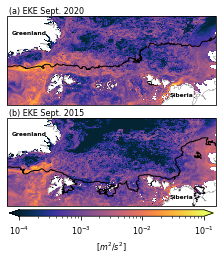

In [19]:
%matplotlib inline
dd=1
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/p/home/jusers/mueller29/juwels/background_img/"
cm2in = 1/2.54  # centimeters in inches
#figsize = (19*cm2in, 11.5*cm2in) #1/2 page
figsize = (9.5*cm2in, 11.5*cm2in) #1/4 page

fig, ax = plt.subplots(
    2,
    1,
    subplot_kw=dict(projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0)),
    figsize=figsize,
)
    
sp = 0
abc='abc'

mesh = pf.load_mesh(mesh_path)
elements = mesh.elem.astype("int32")
lons = mesh.x2
lats = mesh.y2
d = lons[elements].max(axis=1) - lons[elements].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()
triang_ice = mtri.Triangulation(lons, lats, elements[no_cyclic_elem])
#depth = -xr.open_dataset((mesh_path+'fesom.mesh.diag.nc'))['zbar_n_bottom'].astype('float32')

    
for yy in (2020,2015):
    eke_file = out_path+'eke_gridded_monthly_'+str(yy)+'09_'+res+'.npz'
    
    eke_stuff = np.load(eke_file)
    xx_pol = eke_stuff['xx_pol']
    yy_pol = eke_stuff['yy_pol']
    eke_grid = eke_stuff['eke_grid']
    
    ds_ice = xr.open_dataset(
    data_path + "a_ice.fesom." + str(yy) + ".nc",
    chunks={"time": time_split, "nz1": vertical_split},
    )["a_ice"].astype("float32")
    it_ice = ds_ice.time.dt.month == 9
    tmp2 = ds_ice[it_ice, :].mean(dim="time").values.flatten()

    
    ax[sp].set_extent([-50,170,77,90], crs=ccrs.PlateCarree())
    #ax[sp].background_img(name='BM', resolution='high',extent=[-180,180,65,90],cache=True)
    ax[sp].coastlines(resolution='50m',linewidths=.2)

    image = ax[sp].pcolormesh(
        xx_pol[::dd,::dd],
        yy_pol[::dd,::dd],
        eke_grid[::dd,::dd],
        cmap=cmocean.cm.thermal,
        norm=colors.LogNorm(vmin=1e-4, vmax=1e-1),
        shading="auto",
        transform=ccrs.PlateCarree(),
    )

    cont = ax[sp].tricontour(
        triang_ice,
        tmp2,
        [0.15],
        transform=ccrs.PlateCarree(),
        colors="k",
        linewidths=1,
    )
    
    # cont2 = ax[sp].tricontour(
    #     triang_ice,
    #     depth,
    #     [1000,2000,3000,4000,5000],
    #     transform=ccrs.PlateCarree(),
    #     colors='darkgrey',
    #     linewidths=.5,
    # )
    
    #ax[sp].add_feature(cart.feature.LAND, zorder=1, edgecolor="k")
    #ax[sp].text(-45,72,'('+abc[sp]+') '+str(yy),transform=ccrs.PlateCarree(),zorder=100, size=15)
    ax[sp].text(.01, 1.03, '('+abc[sp]+') EKE Sept. '+str(yy),zorder=100, transform=ax[sp].transAxes, size=SMALL_SIZE)
    tt=ax[sp].text(.02, .8, 'Greenland',zorder=100, transform=ax[sp].transAxes, size=6,color='k', weight='bold')
    tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))
    tt=ax[sp].text(.78, .1, 'Siberia',zorder=100, transform=ax[sp].transAxes, size=6,color='k', weight='bold')
    tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))


#    ax[sp].set_title('('+abc[sp]+') '+str(yy))
    sp += 1

chartBox_top=ax[0].get_position()
chartBox_bot=ax[1].get_position()

chartBox = ax[1].get_position()
ax[1].set_position([chartBox.x0, 
              chartBox_top.y0-chartBox_bot.height-0.04, #adjust vertical position of lower plot
              chartBox.width,
              chartBox.height])

#add colorbars      
chartBox1 = ax[1].get_position()
width = chartBox1.width-0.02
cbar_ax = fig.add_axes([chartBox1.x0+0.01, chartBox1.y0-.03, width, 0.02])
cb=fig.colorbar(image,cax=cbar_ax,orientation="horizontal",extend='both')
cb.set_label(r"[$m^2/s^2$]")




if savefig == True:
    fig.savefig(plot_path + 'F4_EKE_2015_2020_'+str(depth)+'.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)


In [9]:
o_path = '/p/project/chhb19/mueller29/data_EKE_paper/'

for yy in (2020,2015):
    eke_file = out_path+'eke_gridded_monthly_'+str(yy)+'09_'+res+'.npz'
    
    eke_stuff = np.load(eke_file)
    xx_pol = eke_stuff['xx_pol']
    yy_pol = eke_stuff['yy_pol']
    eke_grid = eke_stuff['eke_grid']

    dout = xr.Dataset(
        data_vars=dict(
            EKE=(['x', 'y'], eke_grid),
        ),
        coords=dict(
            XX=(['x', 'y'], xx_pol),
            YY=(['x', 'y'], yy_pol),
        ),
        attrs=dict(
            description="eddy kinetic energy",
            units="m2/s2",
        ),
    )     
    dout.to_netcdf((o_path+'Fig4_EKE_25m_'+str(yy)+'09.nc'))